In [33]:
import numpy as np
import os
from scipy import signal
# import UDIP_Lib.UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
import Fitting.RockSat_1_14_fitting_functions as R_fitting
import json
import pandas as pd
import matplotlib.pyplot as plt
from RockSat_json.RockSat_json import *

In [34]:
data = f'../UDIP4/data/json/UDIP_4_800s.json'
figs = '../UDIP4/figs/'

In [35]:
import pandas as pd

# Load the IV.csv file to inspect its structure and data
file_path = 'IV.csv'
iv_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
iv_data.head()
V = iv_data["Voltage"].values
I = -iv_data["Current"].values * 1e9

In [36]:
packets = import_data('../UDIP4/data/json/UDIP_4_800s.json')
sweep = 230
c = 6
V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'][c:]  )
I = -np.array(packets['packets']['Full'][f'{sweep}']['Current0'][c:]) * 1e9
packets['packets']['Full']['200']['Start']/1000

184.941

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

#fitting and helper functions

def gen_fit(x_raw,y_raw):
    x,y = data_processing(x_raw,y_raw)
    g = [2, 2, 2, -14, 80, 5*(10**10), 700 ]    #intial guess
    b = [
        (-3,  -3, 2, -np.inf, -np.inf, 0     , 0    ),
        ( 3,   3, 5, np.inf,  np.inf, np.inf, 5000 )
        ] #bounds
    popt, pcov = optimize.curve_fit(model,x,y,g,bounds=b)
    max_1 = np.max(x)
    min_1 = np.min(x)
    t = np.linspace(min_1,max_1,num=1000)
    return t, model(t,*popt),popt,pcov #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0]

def model(V, Vf, V0, VP,  b, m1, ne, te):
    I = np.zeros(len(V))
    I[V <= Vf] = lin(V[V <= Vf], m1) - lin(Vf, m1) + b
    Vtrans = (V > Vf) & (V < VP)
    I[Vtrans] = exp(V[Vtrans], ne, te, Vf) + b
    I[V >  VP] = sqrt(V[V >  VP], ne, te, V0) - sqrt(VP, ne, te, V0) + b
    return I

def lin(x, m):#linear--full model square root
    return m * x

def exp(x, ne, te, Vf):
    q_e = 1.602e-19  # Electron charge [C]
    K_b = 1.381e-23  # Boltzmann constant [J/K]
    m_e = 9.109e-31  # Electron mass [kg]
    R = (3.0 / 16.0) * 2.54  # Radius of probe [cm]
    L = 3.25 * 2.54  # Length of probe [cm]
    A = 2.0 * np.pi * R * L + np.pi * (R ** 2)  # Surface area [cm^2]
    I0 = ne * q_e * np.sqrt(K_b * te/ (2.0 * np.pi * m_e)) * A * 1e-9  # [nA]
    k = q_e / (K_b * te)
    return I0 * np.exp(k * (x - Vf))

def sqrt(x,n,t,V0):# square root
    q_e = 1.602 * 10**-19 #C                charge of an electron
    K_b = 1.381 * 10**-23 #m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10**-31 #kg               mass of an electron
    R = (3./16.) * 0.0254 #radius of probe
    L = (3.25) * 0.0254 #length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 =n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1.0 + k*(x - V0))

def data_processing(x_raw,y_raw):#remove data points below -2 and above the peak to reduce datapoints going to the fitting routine
    x = np.nan_to_num(x_raw, nan=0.0)
    y = np.nan_to_num(y_raw, nan=0.0)
    x = x[6:]
    y = y[6:]
    return x,y

In [38]:
Vfit, Ifit, popt, pcov = gen_fit(V, I)

/var/folders/vd/xvmkswd51pn4d88fylf_g0kh0000gn/T/ipykernel_55386/3706345134.py:52: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1.0 + k*(x - V0))


[2.54117755e+00 2.24842070e+00 2.19915296e+00 1.81863926e+01
 9.46388775e+00 1.01907947e+10 5.81433589e+02]


/var/folders/vd/xvmkswd51pn4d88fylf_g0kh0000gn/T/ipykernel_55386/3706345134.py:52: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1.0 + k*(x - V0))


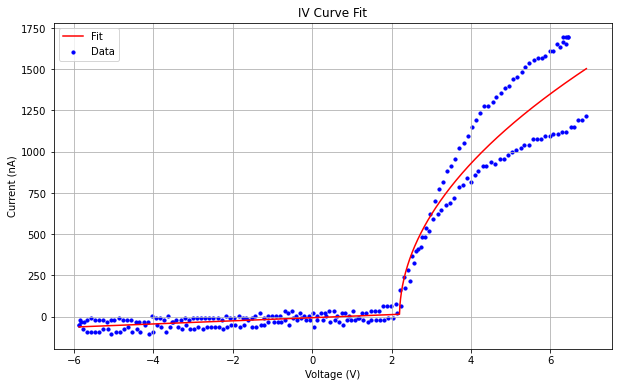

In [39]:
packets = import_data('../UDIP4/data/json/UDIP_4_800s.json')
sweep = 290
c = 6
V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'][c:]  )
I = -np.array(packets['packets']['Full'][f'{sweep}']['Current0'][c:]) * 1e9
Vfit, Ifit, popt, pcov = gen_fit(V, I)

print(popt)

packets['packets']['Full']['200']['Start']/1000
plt.figure(figsize=(10, 6))
plt.scatter(V, I, label="Data", color="blue", s=10)
plt.plot(Vfit, Ifit, label="Fit", color="red")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.title("IV Curve Fit")
# plt.xlim(2.07, 2.5)
plt.legend()
plt.grid()
plt.savefig(figs + 'IV.png')

/var/folders/vd/xvmkswd51pn4d88fylf_g0kh0000gn/T/ipykernel_55386/3706345134.py:52: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1.0 + k*(x - V0))


[2.54117755e+00 2.24842070e+00 2.19915296e+00 1.81863926e+01
 9.46388775e+00 1.01907947e+10 5.81433589e+02]


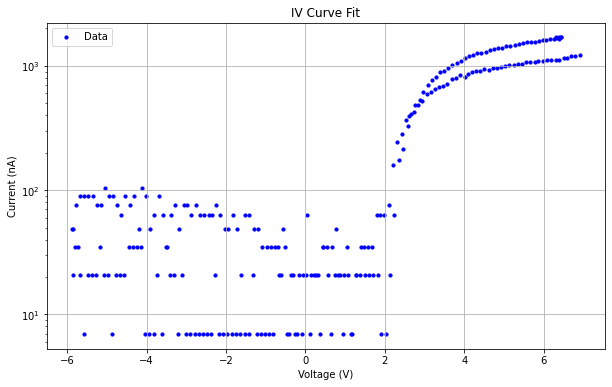

In [48]:
packets = import_data('../UDIP4/data/json/UDIP_4_800s.json')
sweep = 290
c = 6
V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'][c:]  )
I = -np.array(packets['packets']['Full'][f'{sweep}']['Current0'][c:]) * 1e9
Vfit, Ifit, popt, pcov = gen_fit(V, I)

print(popt)

packets['packets']['Full']['200']['Start']/1000
plt.figure(figsize=(10, 6))
plt.scatter(V, np.abs(I), label="Data", color="blue", s=10)
plt.yscale('log')
# plt.plot(Vfit, Ifit, label="Fit", color="red")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.title("IV Curve Fit")
# plt.xlim(2.07, 2.5)
plt.legend()
plt.grid()
plt.savefig(figs + 'IV.png')

In [41]:
print(popt)

[2.54117755e+00 2.24842070e+00 2.19915296e+00 1.81863926e+01
 9.46388775e+00 1.01907947e+10 5.81433589e+02]


In [42]:
starting_sweep = 400
st = packets['packets']['Full'][f'{starting_sweep}']['Start']
print((st/1000)-57)

204.86599999999999


In [43]:
ne = np.array([])
Te = np.array([])
Imax = np.array([])
t_lin = np.array([])
starting_sweep = 0
stopping_sweep = 900
st = packets['packets']['Full'][f'{starting_sweep}']['Start']
fin = packets['packets']['Full'][f'{stopping_sweep}']['Start']
# print((st/1000) - 57,(fin/1000) - 57)
# print(len(packets['packets']['Full']))
step   = 1
for sweep in range(starting_sweep, stopping_sweep, step):
    c = 6
    V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'][c:]) 
    I = -np.array(packets['packets']['Full'][f'{sweep}']['Current0'][c:]) * 1e9
    Vfit, Ifit, popt, pcov = gen_fit(V, I)
    start = packets['packets']['Full'][f'{sweep}']['Start']
    stop  = packets['packets']['Full'][f'{sweep}']['Stop']
    t_lin = np.append(t_lin, (start + stop)/2/1000 - 57)
    ne = np.append(ne,popt[5])
    Te = np.append(Te,popt[6])
    Imax = np.append(Imax, np.max(I))

/var/folders/vd/xvmkswd51pn4d88fylf_g0kh0000gn/T/ipykernel_55386/3706345134.py:52: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1.0 + k*(x - V0))
/var/folders/vd/xvmkswd51pn4d88fylf_g0kh0000gn/T/ipykernel_55386/3706345134.py:40: RuntimeWarning: overflow encountered in exp
  return I0 * np.exp(k * (x - Vf))


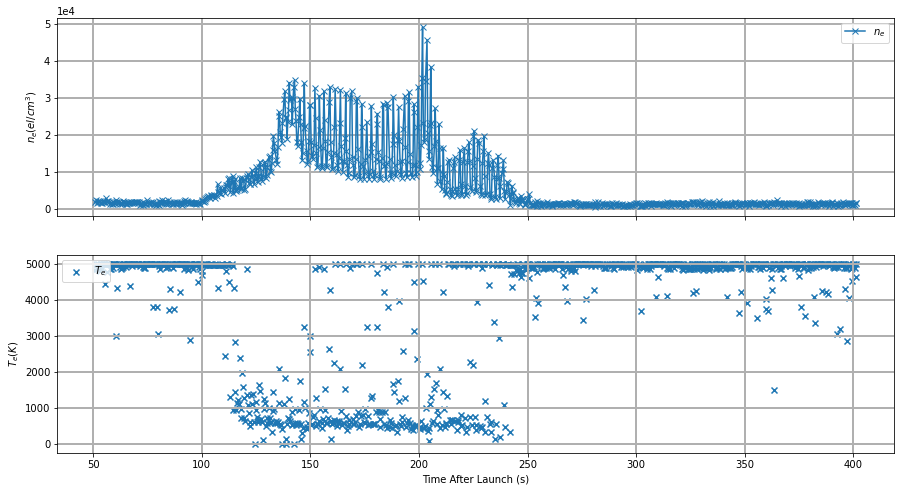

In [44]:
fig, ax = plt.subplots(2,1, figsize = (15, 8), sharex = True)
ax[0].plot(t_lin, ne * 1e-6, marker = 'x', label = r'$n_e$')
# ax[0].plot(tav_lin, ne_av, marker = '.', markersize = 8, label = r'$\langle n_e \rangle$')
ax[0].legend()
ax[0].grid(linewidth = 2)
# ax[0].set_xlabel('Time After Launch (s)')
ax[0].set_ylabel(r'$n_e (el/cm^3)$')
ax[1].scatter(t_lin, Te, marker = 'x', label = r'$T_e$')
# ax[1].plot(tav_lin, Te_av, marker = '.', markersize = 8, label = r'$\langle T_e \rangle$')
ax[1].grid(linewidth = 2)
ax[1].set_xlabel('Time After Launch (s)')
ax[1].set_ylabel(r'$T_e (K)$')
ax[0].ticklabel_format(axis='y', scilimits=(0,0))
# ax[1].set_ylim(0, 1500)
# ax[1].set_xlim(110, 221)
ax[1].legend(loc = 'upper left')
fig.savefig(figs + 'ne_Te.png')